In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import pandas as pd
import lasagne
from parmesan.distributions import log_bernoulli, kl_normal2_stdnormal
from parmesan.layers import SimpleSampleLayer
from keras.datasets import mnist
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)
Using Theano backend.


In [2]:
#settings
do_train_model = False
batch_size = 100
latent_size = 20
nhidden = 512
lr = 0.001
num_epochs = 50
model_filename = "mnist_vae"
nonlin = lasagne.nonlinearities.rectify

np.random.seed(1234) # reproducibility

In [3]:
#SYMBOLIC VARS
sym_x = T.matrix()
sym_lr = T.scalar('lr')

### LOAD DATA
print "Using MNIST dataset"

(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = (train_x.reshape((-1, 784))/255.0).astype(np.float32)
test_x = (test_x.reshape((-1, 784))/255.0).astype(np.float32)

train_x[train_x > 0.5] = 1.0
train_x[train_x <= 0.5] = 0.0

train_x[train_x > 0.5] = 1.0
train_x[train_x <= 0.5] = 0.0

#setup shared variables
sh_x_train = theano.shared(train_x, borrow=True)
sh_x_test = theano.shared(test_x, borrow=True)

nfeatures=train_x.shape[1]
n_train_batches = train_x.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

Using MNIST dataset


In [4]:
### RECOGNITION MODEL q(z|x)
l_in = lasagne.layers.InputLayer((batch_size, nfeatures))
l_noise = lasagne.layers.BiasLayer(l_in, b = np.zeros(nfeatures, dtype = np.float32), name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
l_enc_h1 = lasagne.layers.DenseLayer(l_noise, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE1')
l_enc_h1 = lasagne.layers.DenseLayer(l_enc_h1, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE2')

l_mu = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_MU')
l_log_var = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_LOG_VAR')

#sample the latent variables using mu(x) and log(sigma^2(x))
l_z = SimpleSampleLayer(mean=l_mu, log_var=l_log_var)

In [5]:
### GENERATIVE MODEL p(x|z)
l_dec_h1 = lasagne.layers.DenseLayer(l_z, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE2')
l_dec_h1 = lasagne.layers.DenseLayer(l_dec_h1, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE1')
l_dec_x_mu = lasagne.layers.DenseLayer(l_dec_h1, num_units=nfeatures, nonlinearity=lasagne.nonlinearities.sigmoid, name='DEC_X_MU')

# Get outputs from model
# with noise
z_train, z_mu_train, z_log_var_train, x_mu_train = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu], sym_x, deterministic=False
)

# without noise
z_eval, z_mu_eval, z_log_var_eval, x_mu_eval = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu], sym_x, deterministic=True
)

In [6]:
#Calculate the loglikelihood(x) = E_q[ log p(x|z) + log p(z) - log q(z|x)]
def ELBO(z, z_mu, z_log_var, x_mu, x):
    """
    Latent z       : gaussian with standard normal prior
    decoder output : bernoulli

    When the output is bernoulli then the output from the decoder
    should be sigmoid. The sizes of the inputs are
    z: (batch_size, num_latent)
    z_mu: (batch_size, num_latent)
    z_log_var: (batch_size, num_latent)
    x_mu: (batch_size, num_features)
    x: (batch_size, num_features)
    """
    kl_term = kl_normal2_stdnormal(z_mu, z_log_var).sum(axis=1)
    log_px_given_z = log_bernoulli(x, x_mu, eps=1e-6).sum(axis=1)
    LL = T.mean(-kl_term + log_px_given_z)

    return LL

# TRAINING LogLikelihood
LL_train = ELBO(z_train, z_mu_train, z_log_var_train, x_mu_train, sym_x)

# EVAL LogLikelihood
LL_eval = ELBO(z_eval, z_mu_eval, z_log_var_eval, x_mu_eval, sym_x)

params = lasagne.layers.get_all_params(l_dec_x_mu, trainable=True)
for p in params:
    print p, p.get_value().shape

### Take gradient of Negative LogLikelihood
grads = T.grad(-LL_train, params)

# Add gradclipping to reduce the effects of exploding gradients.
# This speeds up convergence
clip_grad = 1
max_norm = 5
mgrads = lasagne.updates.total_norm_constraint(grads,max_norm=max_norm)
cgrads = [T.clip(g,-clip_grad, clip_grad) for g in mgrads]

ENC_DENSE1.W (784, 512)
ENC_DENSE1.b (512,)
ENC_DENSE2.W (512, 512)
ENC_DENSE2.b (512,)
ENC_Z_MU.W (512, 20)
ENC_Z_MU.b (20,)
ENC_Z_LOG_VAR.W (512, 20)
ENC_Z_LOG_VAR.b (20,)
DEC_DENSE2.W (20, 512)
DEC_DENSE2.b (512,)
DEC_DENSE1.W (512, 512)
DEC_DENSE1.b (512,)
DEC_X_MU.W (512, 784)
DEC_X_MU.b (784,)


In [7]:
#Setup the theano functions
sym_batch_index = T.iscalar('index')
batch_slice = slice(sym_batch_index * batch_size, (sym_batch_index + 1) * batch_size)

updates = lasagne.updates.adam(cgrads, params, learning_rate=sym_lr)

train_model = theano.function([sym_batch_index, sym_lr], LL_train, updates=updates,
                                  givens={sym_x: sh_x_train[batch_slice]},)

test_model = theano.function([sym_batch_index], LL_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

plot_results = theano.function([sym_batch_index], x_mu_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

def train_epoch(lr):
    costs = []
    for i in range(n_train_batches):
        cost_batch = train_model(i, lr)
        costs += [cost_batch]
    return np.mean(costs)


def test_epoch():
    costs = []
    for i in range(n_test_batches):
        cost_batch = test_model(i)
        costs += [cost_batch]
    return np.mean(costs)

In [8]:
if do_train_model:
    # Training Loop
    for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x)
        sh_x_train.set_value(train_x)
        
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print line
    
    print "Write model data"
    write_model([l_dec_x_mu], model_filename)
else:
    read_model([l_dec_x_mu], model_filename)
    

In [25]:
def show_mnist(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(28, 28)
    img = np.clip(img, 0, 1)
    plt.subplot(2, 3, i)
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.axis("off")
    
def mnist_input(img):
    return np.tile(img, (batch_size, 1, 1, 1)).reshape(batch_size, 784)

def mnist_dist(imgs, img):
    assert imgs.shape == (batch_size, 784)
    diff = np.linalg.norm(imgs - img, axis = 1)
    return np.mean(diff), np.std(diff)

In [10]:
def kld(mean1, log_var1, mean2, log_var2):
    mean_term = (T.exp(0.5*log_var1) + (mean1-mean2)**2.0)/T.exp(0.5*log_var2)
    return mean_term + log_var2 - log_var1 - 0.5

# Autoencoder outputs
mean, log_var, reconstruction = lasagne.layers.get_output(
    [l_mu, l_log_var, l_dec_x_mu], inputs = sym_x, deterministic=True)
    
# Adversarial confusion cost function
    
# Mean squared reconstruction difference
# KL divergence between latent variables
adv_mean =  T.vector()
adv_log_var = T.vector()
adv_confusion = kld(mean, log_var, adv_mean, adv_log_var).sum()

# Adversarial regularization
C = T.scalar()
adv_reg = C*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([sym_x, adv_mean, adv_log_var, C], [adv_loss, adv_grad])

# Helper to plot reconstructions    
adv_plot = theano.function([sym_x], reconstruction)

# Function to get latent variables of the target
adv_mean_log_var = theano.function([sym_x], [mean, log_var])

In [38]:
def adv_test(orig_img, target_img, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((784,)).astype(np.float32))
    
    # Get latent variables of the target
    adv_mean_values, adv_log_var_values = adv_mean_log_var(mnist_input(test_x[target_img]))
    adv_mean_values = adv_mean_values[0]
    adv_log_var_values = adv_log_var_values[0]

    original_reconstructions = adv_plot(mnist_input(test_x[orig_img]))
    target_reconstructions = adv_plot(mnist_input(test_x[target_img]))

    orig_recon_dist, orig_recon_dist_std = mnist_dist(original_reconstructions, test_x[orig_img])
    target_recon_dist, target_recon_dist_std = mnist_dist(target_reconstructions, test_x[target_img])
    orig_target_recon_dist, orig_target_recon_dist_std = mnist_dist(original_reconstructions, test_x[target_img])
    target_orig_recon_dist, target_orig_recon_dist_std = mnist_dist(target_reconstructions, test_x[orig_img])

    # Plot original reconstruction    
    if plot:
        plt.figure()
        show_mnist(test_x[orig_img], 1, "Original")
        show_mnist(original_reconstructions[0], 2, "Original rec.")

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(784,)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.astype(np.float32))
        f, g = adv_function(mnist_input(test_x[orig_img]), adv_mean_values, adv_log_var_values, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-test_x[orig_img], 1-test_x[orig_img])
    
    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_imgs = adv_plot(mnist_input(test_x[orig_img]))
    
    orig_dist, orig_dist_std = mnist_dist(adv_imgs, test_x[orig_img])
    adv_dist, adv_dist_std = mnist_dist(adv_imgs, test_x[target_img])
    recon_dist, recon_dist_std = mnist_dist(adv_imgs, test_x[orig_img]+x)
    
    # Plotting results
    if plot:
        show_mnist((test_x[orig_img].flatten()+x), 3, "Adversarial")
        show_mnist(test_x[target_img], 4, "Target")
        show_mnist(adv_imgs[0], 5, "Adversarial rec.")
        show_mnist(x, 6, "Distortion")
        plt.show()
            
    orig_target_dist = np.linalg.norm(test_x[orig_img] - test_x[target_img])
    
    returns = (np.linalg.norm(x),
               orig_dist, 
               orig_dist_std, 
               adv_dist, 
               adv_dist_std, 
               orig_recon_dist, 
               orig_recon_dist_std, 
               target_recon_dist, 
               target_recon_dist_std,
               recon_dist,
               recon_dist_std,
               orig_target_dist,
               orig_target_recon_dist,
               orig_target_recon_dist_std,
               target_orig_recon_dist,
               target_orig_recon_dist_std)
    
    return returns

In [39]:
def orig_adv_dist(orig_img = None, target_img = None, plot = False, bestC = None):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_label = test_y[orig_img]
        while target_label == test_y[orig_img]:
            target_img = np.random.randint(0, len(test_x))
            target_label = test_y[target_img]
    
    noise_dist = []
    orig_dist=[]
    orig_dist_std=[]
    adv_dist=[]
    adv_dist_std=[]
    target_recon_dist=[]
    target_recon_dist_std=[]
    recon_dist=[]
    recon_dist_std=[]
    orig_target_dist=[]
    orig_target_recon_dist=[]
    orig_target_recon_dist_std=[]
    target_orig_recon_dist=[]
    target_orig_recon_dist_std=[]
    
    C = np.logspace(-20, 20, 100, base = 2, dtype = np.float32)
    
    for c in C:
        noise, od, ods, ad, ads, ore, ores, tre, tres, recd, recs, otd, otrd, otrds, tord, tords = adv_test(orig_img, target_img, C=c, plot = False)
        noise_dist.append(noise)
        orig_dist.append(od)
        orig_dist_std.append(ods)
        adv_dist.append(ad)
        adv_dist_std.append(ads)
        target_recon_dist.append(tre)
        target_recon_dist_std.append(tres)
        recon_dist.append(recd)
        recon_dist_std.append(recs)
        orig_target_dist.append(otd)
        orig_target_recon_dist.append(otrd)
        orig_target_recon_dist_std.append(otrds)
        target_orig_recon_dist.append(tord)
        target_orig_recon_dist_std.append(tords)

    noise_dist = np.array(noise_dist)
    orig_dist = np.array(orig_dist)
    orig_dist_std = np.array(orig_dist_std)
    adv_dist = np.array(adv_dist)
    adv_dist_std = np.array(adv_dist_std)
    target_recon_dist = np.array(target_recon_dist)
    target_recon_dist_std = np.array(target_recon_dist_std)
    recon_dist = np.array(recon_dist)
    recon_dist_std = np.array(recon_dist_std)
    orig_target_dist = np.array(orig_target_dist)
    orig_target_recon_dist = np.array(orig_target_recon_dist)
    orig_target_recon_dist_std = np.array(orig_target_recon_dist_std)
    target_orig_recon_dist = np.array(target_orig_recon_dist)
    target_orig_recon_dist_std = np.array(target_orig_recon_dist_std)
    
    if bestC is None:
        bestC = C[np.argmax(adv_dist - orig_dist >= 0)-1]

    print orig_img, target_img, bestC

    ex_noise, _, _, ex_adv_dist, _, orig_reconstruction_dist, _, target_reconstruction_dist, _, _, _, ex_orig_target_dist, ex_orig_target_recon_dist, _, _, _ = adv_test(orig_img, target_img, C=bestC, plot = plot)

    if plot:
        plt.figure()
        plt.axvline(x=ex_orig_target_dist, linewidth = 2, color='cyan', label = "Original - Target")
        plt.axhline(y=ex_orig_target_recon_dist, linewidth = 2, color = 'DarkOrange', label = "Original rec. - Target")
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'red', label = "Target rec. - Target")
        plt.scatter(noise_dist, adv_dist)
        plt.scatter([ex_noise], [ex_adv_dist], color = "red")
        plt.ylabel("Adversarial rec. - Target")
        plt.xlabel("Distortion")
        plt.legend()
        plt.plot()
        
    df = pd.DataFrame({'orig_img': orig_img,
                       'target_img': target_img,
                       'bestC': bestC,
                       'orig_reconstruction_dist': orig_reconstruction_dist,
                       'target_reconstruction_dist': target_reconstruction_dist,
                       'noise_dist': noise_dist,
                       'orig_dist': orig_dist,
                       'orig_dist_std': orig_dist_std,
                       'adv_dist': adv_dist,
                       'adv_dist_std': adv_dist_std,
                       'target_recon_dist': target_recon_dist,
                       'target_recon_dist_std': target_recon_dist_std,
                       'recon_dist': recon_dist,
                       'recon_dist_std': recon_dist_std,
                       'orig_target_dist': orig_target_dist,
                       'orig_target_recon_dist': orig_target_recon_dist,
                       'orig_target_recon_dist_std': orig_target_recon_dist_std,
                       'target_orig_recon_dist': target_orig_recon_dist,
                       'target_orig_recon_dist_std': target_orig_recon_dist_std,
                       'C': C})
    
    return df

8776 2417 177.878


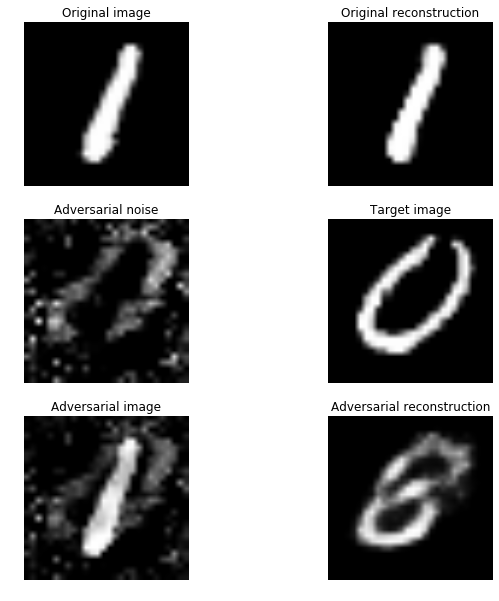

Iter 0 Time 189.809438944 sec
6192 8110 177.878


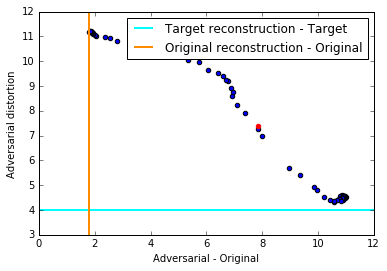

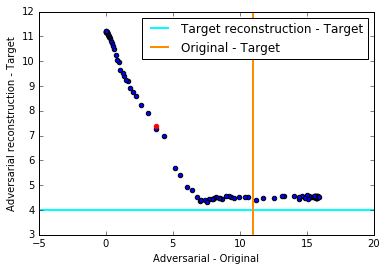

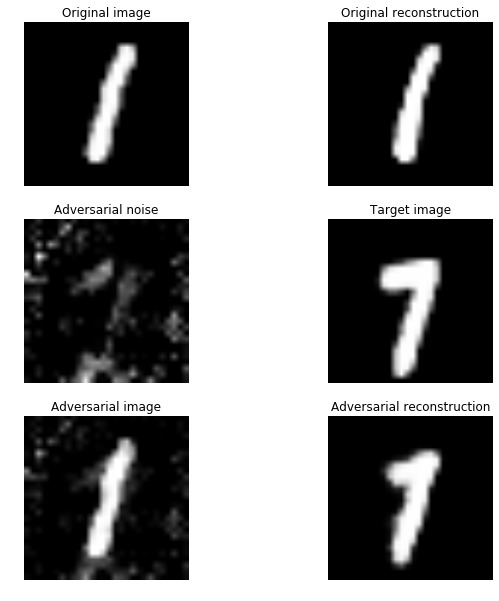

Iter 1 Time 252.576683044 sec
1535 1940 311.444


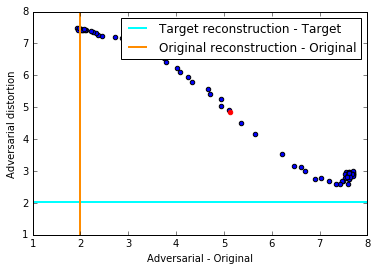

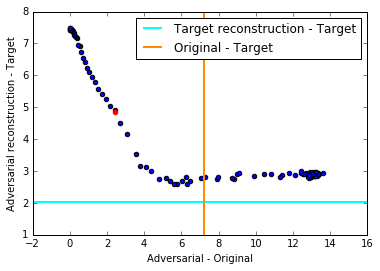

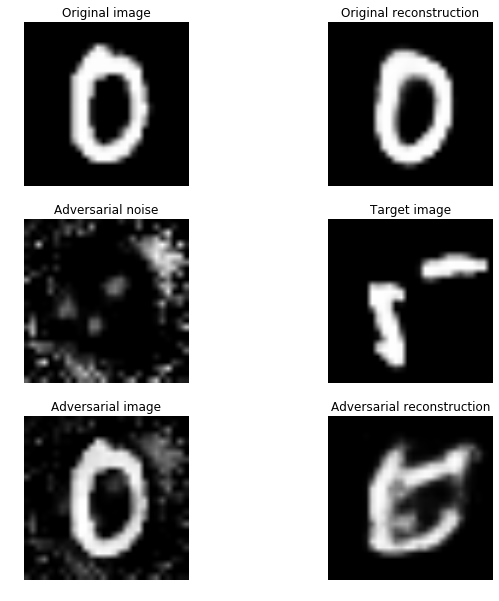

Iter 2 Time 230.008036137 sec
3134 9112 134.43


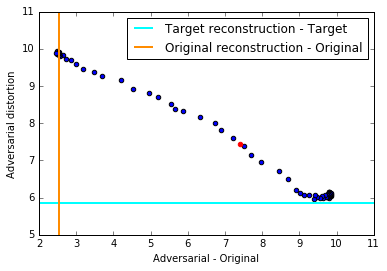

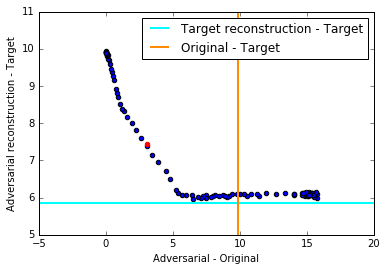

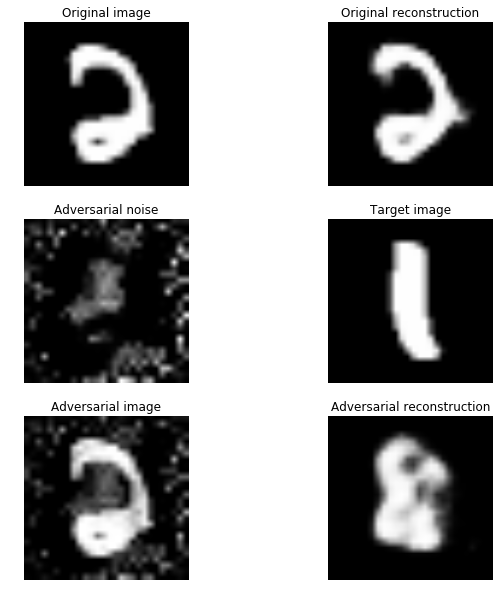

Iter 3 Time 250.53234005 sec
7254 2299 412.105


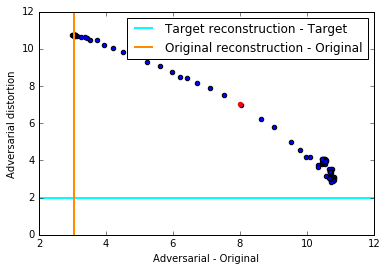

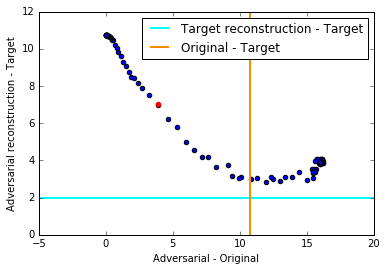

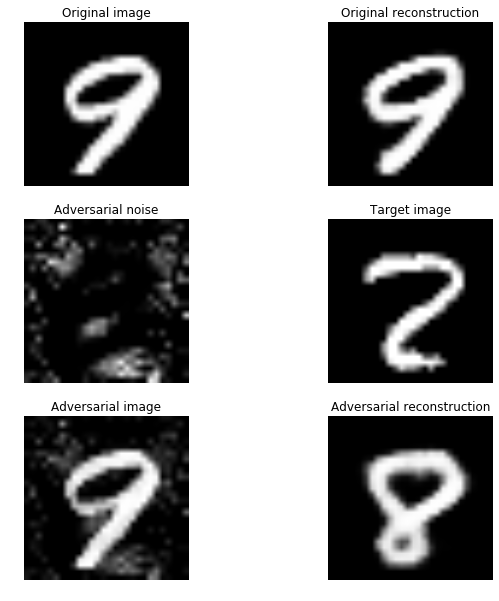

Iter 4 Time 210.576869965 sec
6239 2126 177.878


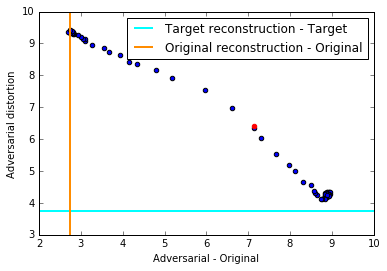

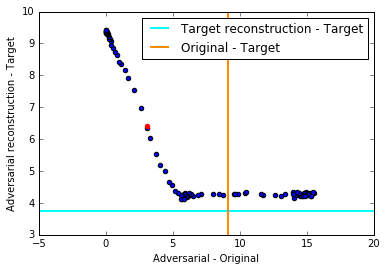

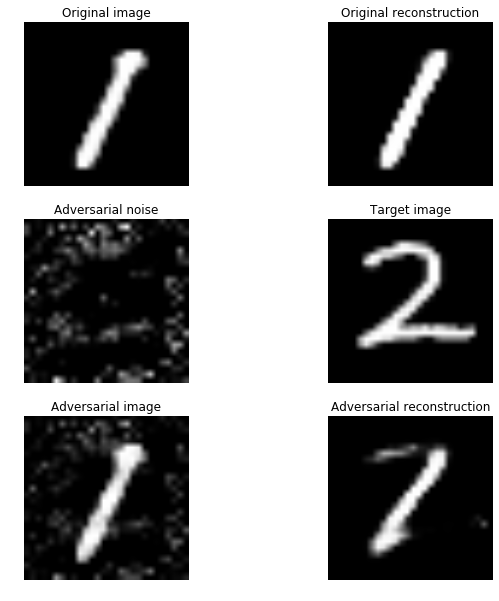

Iter 5 Time 235.669589996 sec
9169 9615 412.105


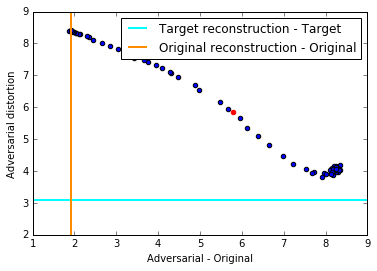

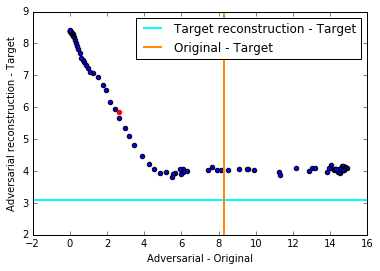

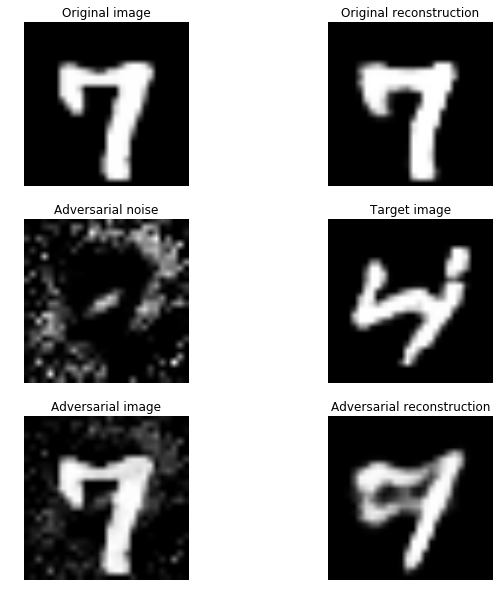

Iter 6 Time 113.872303009 sec
7661 1453 235.37


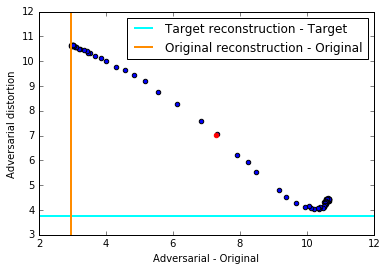

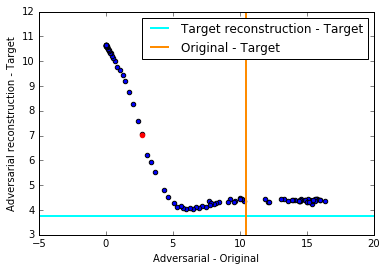

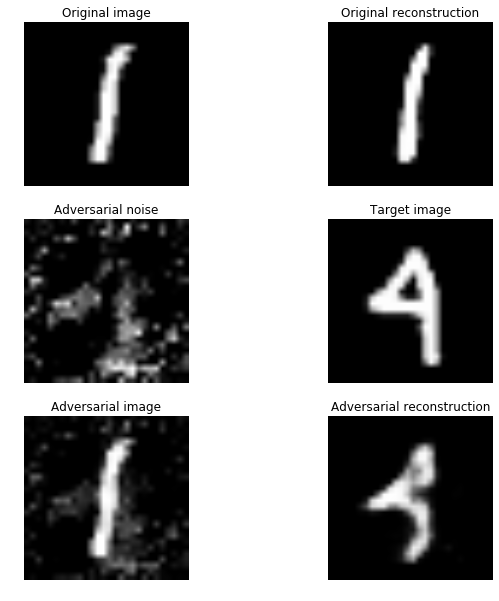

Iter 7 Time 209.586770058 sec
6954 4864 235.37


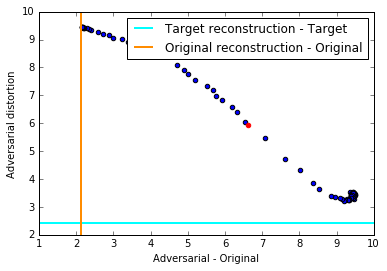

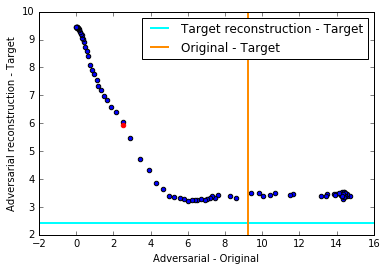

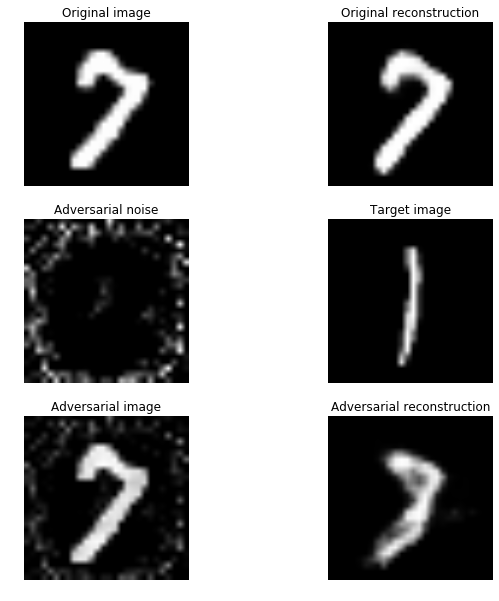

Iter 8 Time 245.405713081 sec
5593 2372 235.37


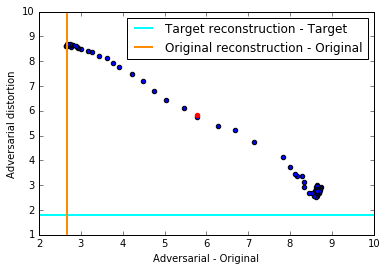

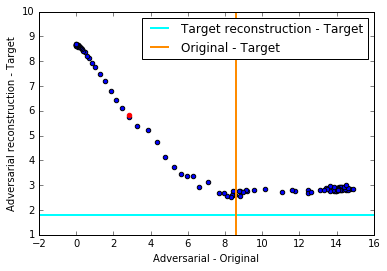

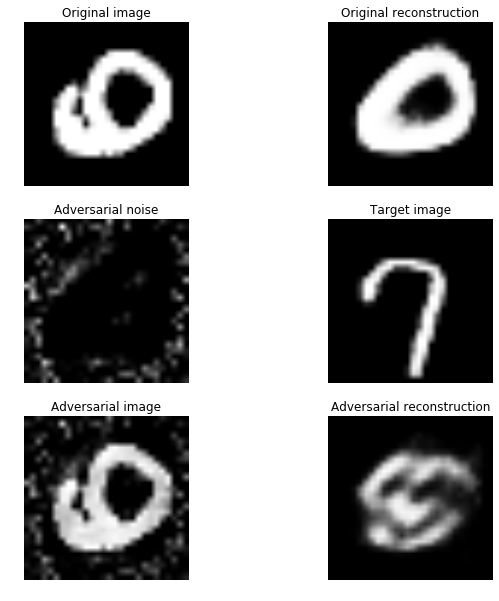

Iter 9 Time 298.494830132 sec
5353 1542 134.43


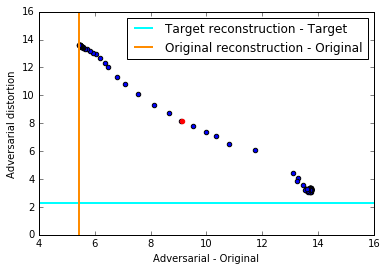

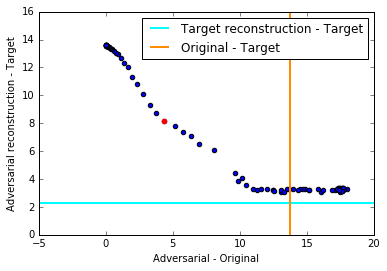

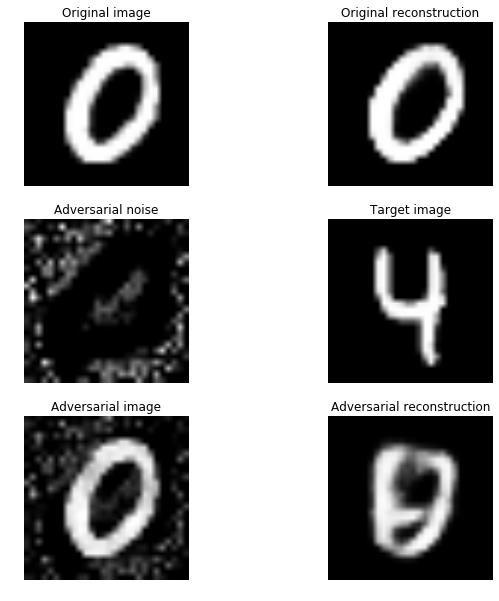

Iter 10 Time 226.072021961 sec
161 7840 311.444


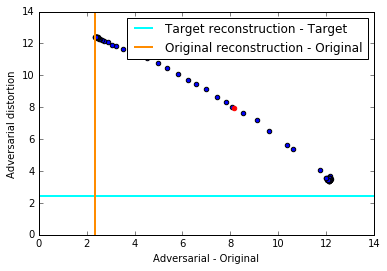

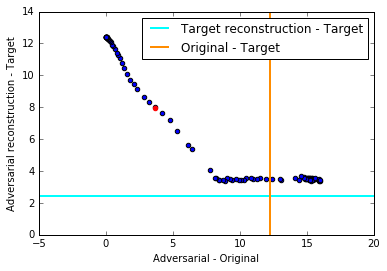

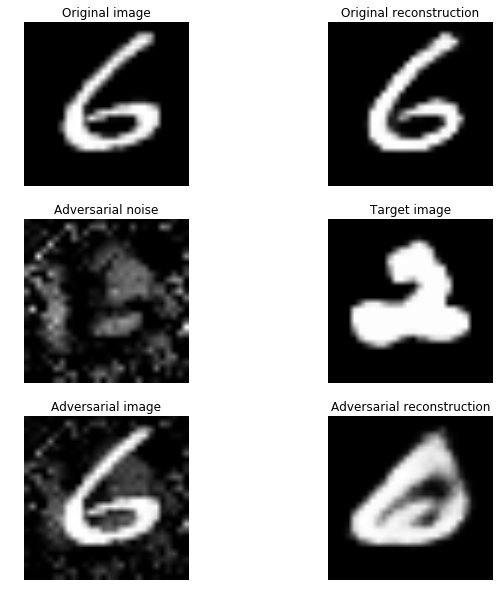

Iter 11 Time 139.669890881 sec
5724 2614 311.444


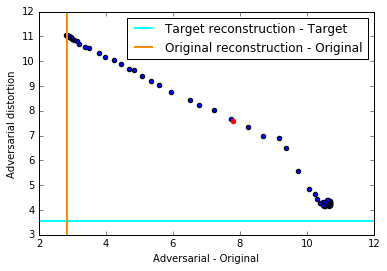

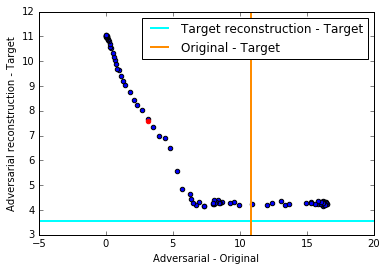

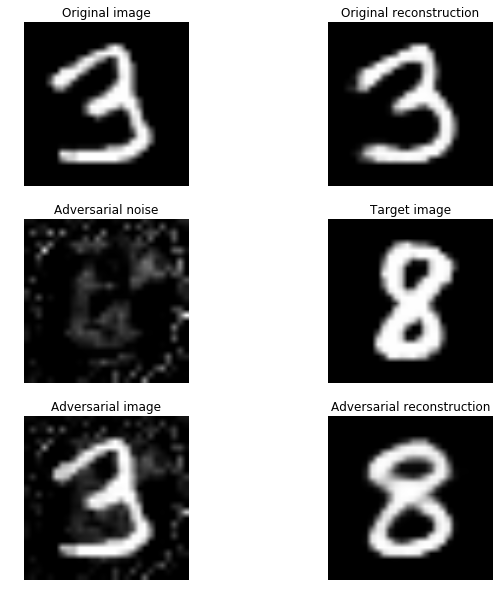

Iter 12 Time 160.174939156 sec
3114 6984 177.878


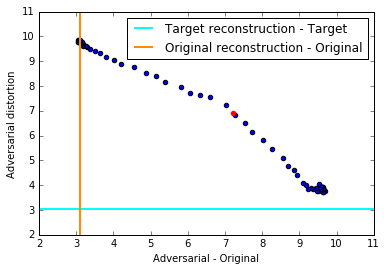

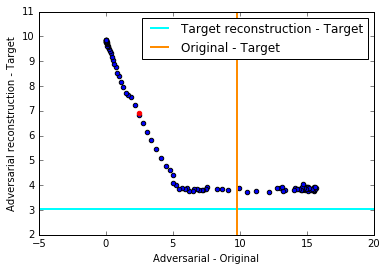

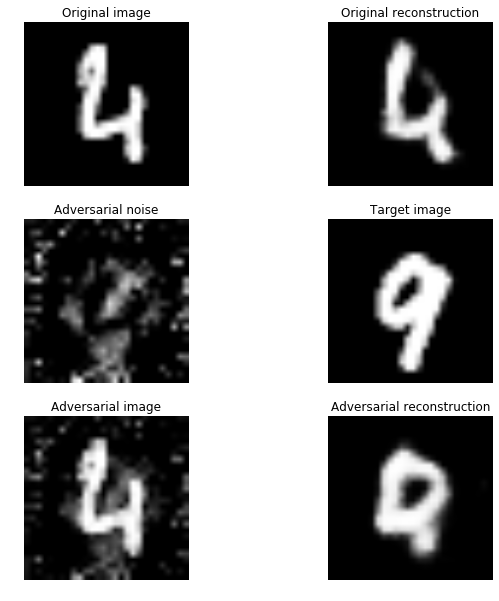

Iter 13 Time 152.092961073 sec
6706 4138 76.7783


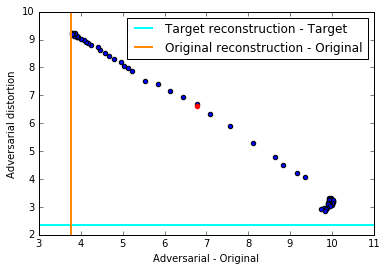

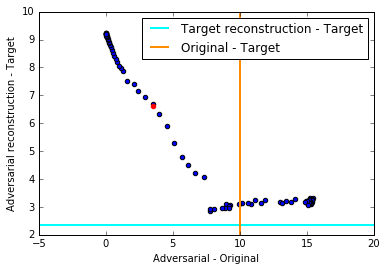

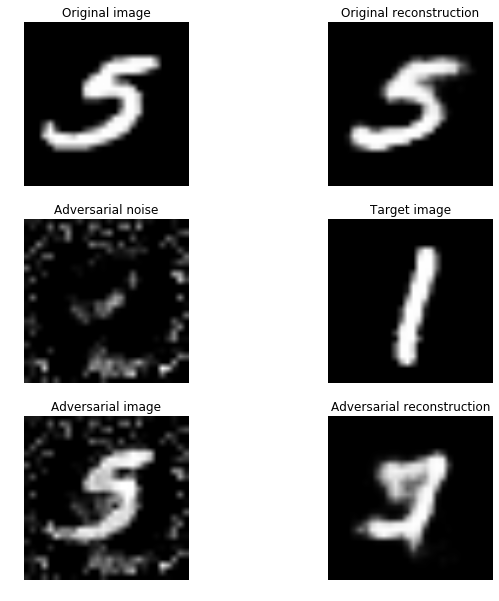

Iter 14 Time 200.80833292 sec
5592 3990 101.594


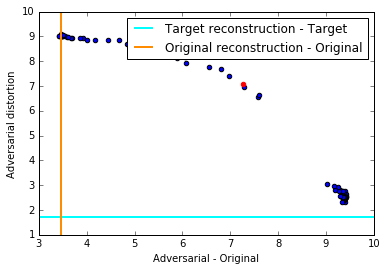

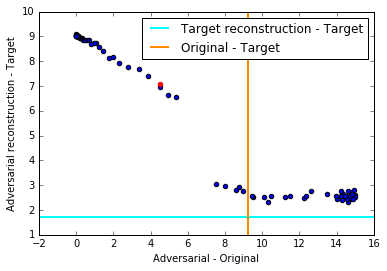

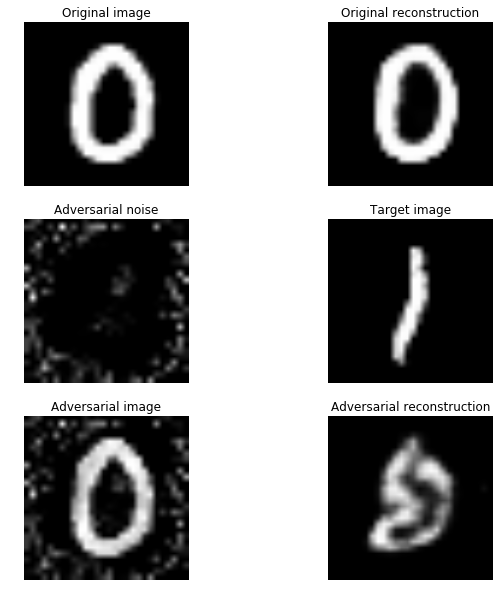

Iter 15 Time 226.40637207 sec
2438 5835 177.878


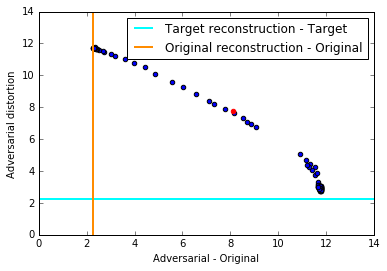

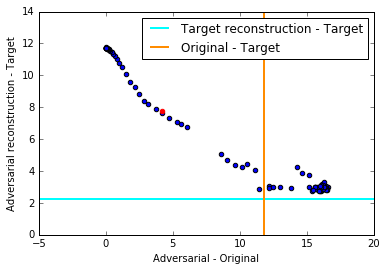

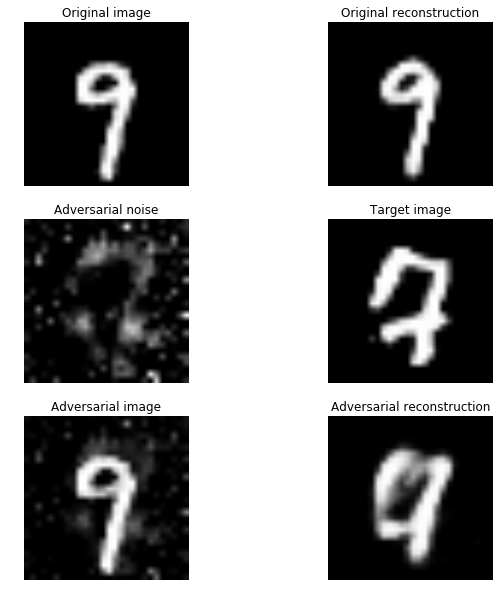

Iter 16 Time 128.897346973 sec
3597 3633 235.37


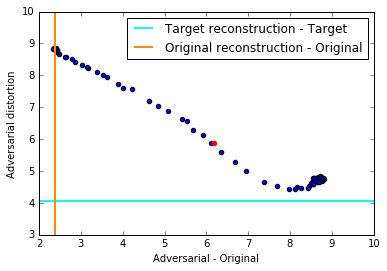

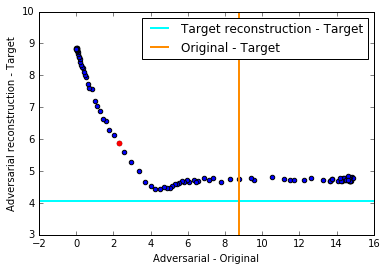

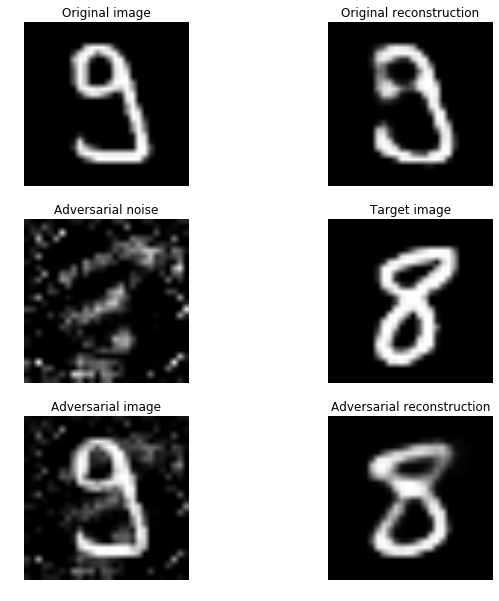

Iter 17 Time 210.814279079 sec
4532 5263 235.37


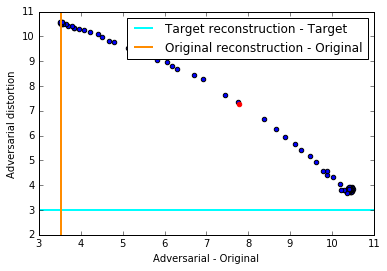

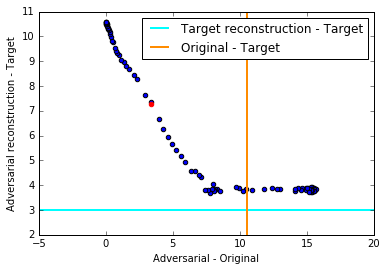

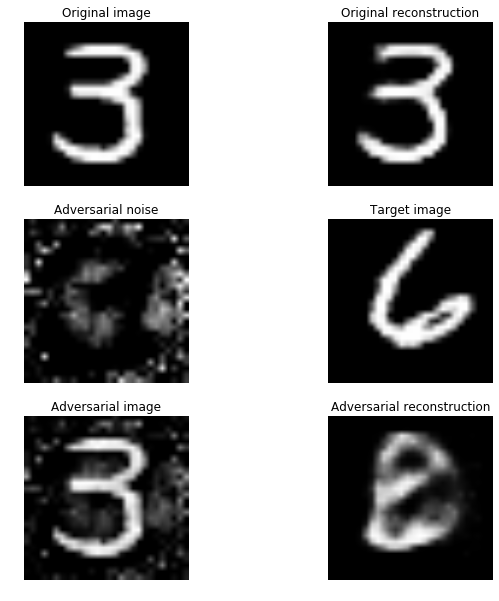

Iter 18 Time 216.773715973 sec
5768 9059 311.444


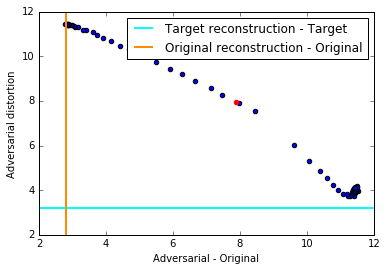

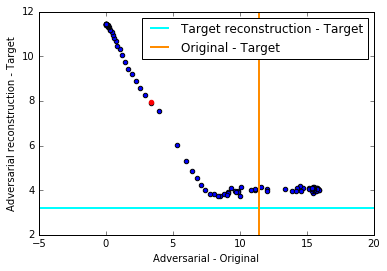

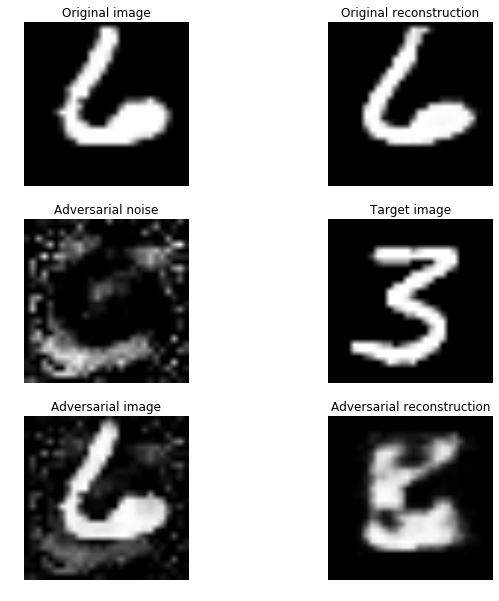

Iter 19 Time 229.876502037 sec
972 275 134.43


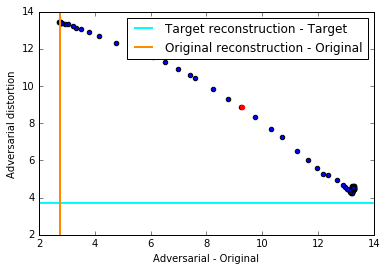

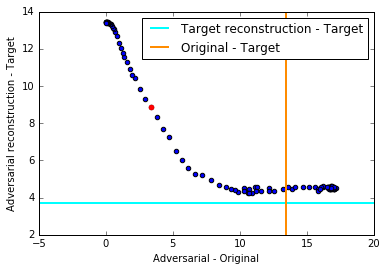

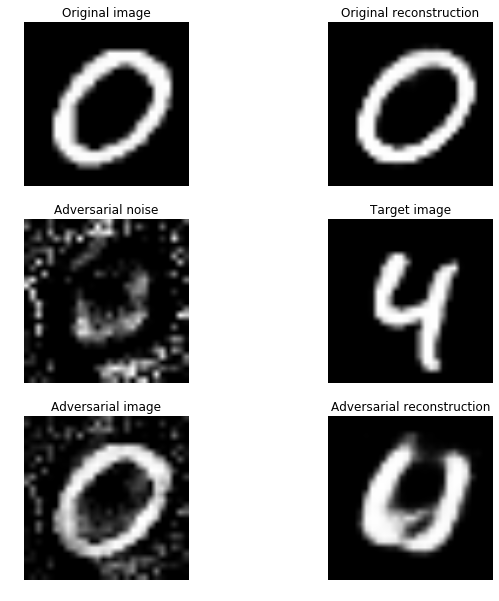

Iter 20 Time 202.223810911 sec
5803 8403 134.43


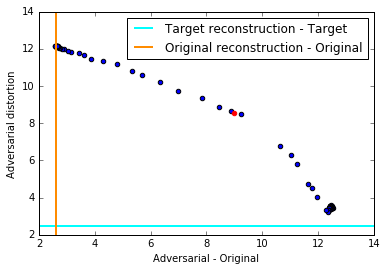

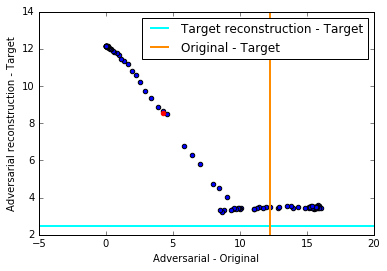

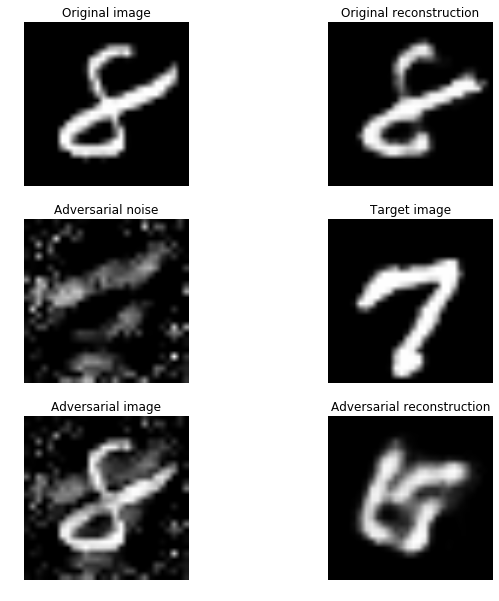

Iter 21 Time 211.884047031 sec
2971 3798 311.444


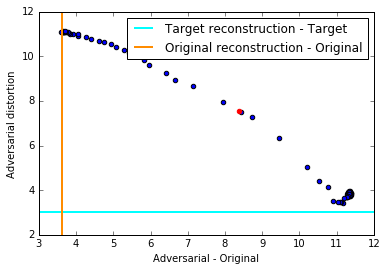

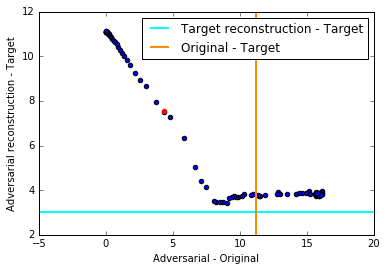

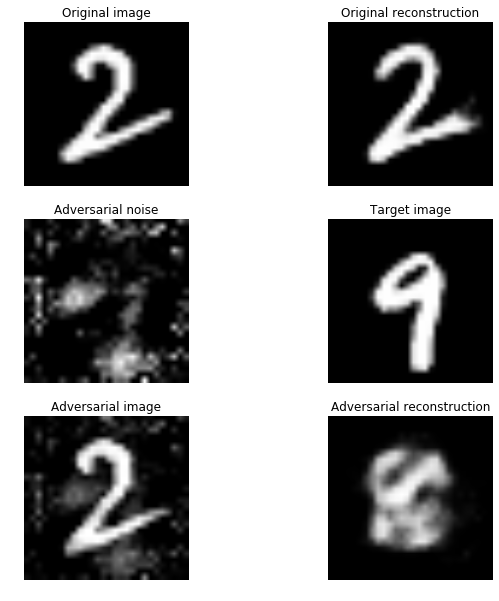

Iter 22 Time 171.245383024 sec
3562 7898 177.878


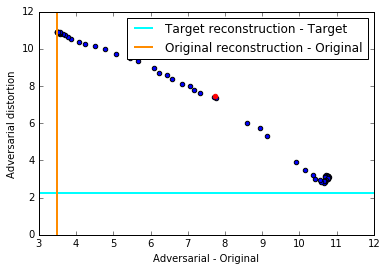

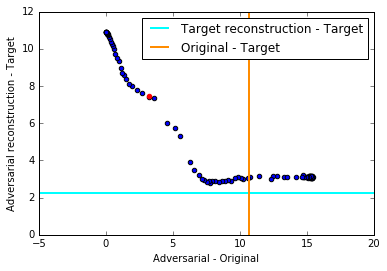

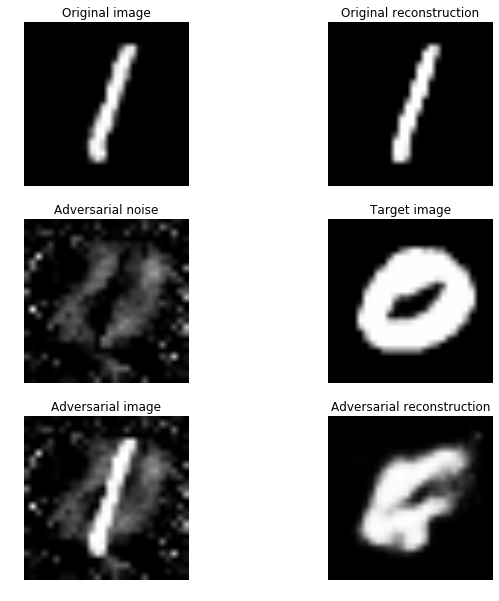

Iter 23 Time 155.481889963 sec
6883 8851 235.37


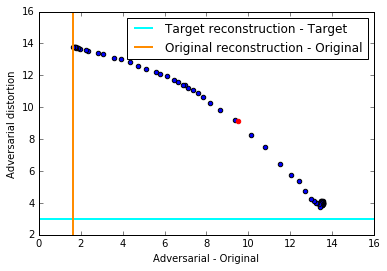

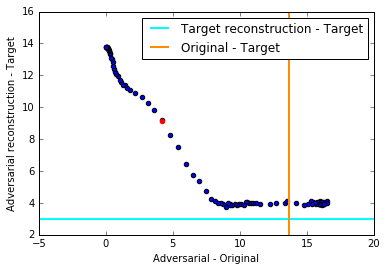

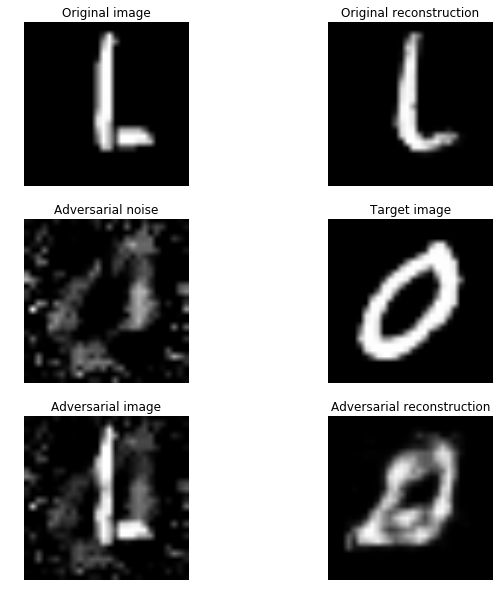

Iter 24 Time 204.979635954 sec


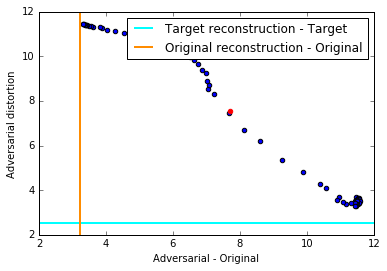

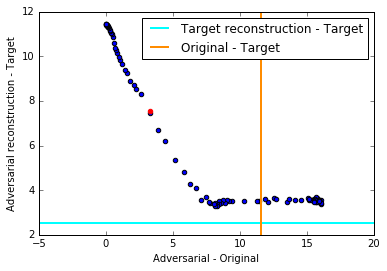

In [19]:
n = 25

for i in range(n):
    start_time = time.time()
    df = orig_adv_dist(plot = True)
    print "Iter", i, "Time", time.time() - start_time, "sec"
    df.to_csv("results/" + model_filename + "/exp_" + str(i) + ".csv")
    

9791 3405 50


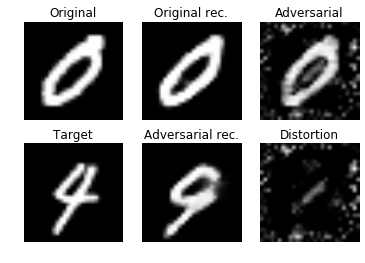

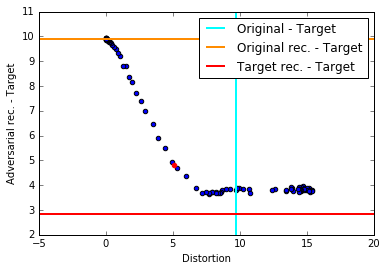

In [40]:
df = orig_adv_dist(9791, 3405, plot = True, bestC = 50)